In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sympy
import mpmath
from scipy import stats
from sklearn.neighbors import KernelDensity
import functools
import pandas as pd
import math
import random
import seaborn as sns
import itertools
from itertools import groupby
#import separation_algorithm as sepa
#import functions_eye_tracker_project as funcs
import sklearn
import os
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
import copy
import scipy.io
from statsmodels.tsa.stattools import pacf
import emd
import matplotlib
from MFDFA import MFDFA
import statsmodels.api as sm

In [4]:
dir_path = r'/Users/pedroreg/Desktop/research copy/tiny paper/eyelink_tiny_data/eyelink_tiny_data/'

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)
#print(res)
res = np.sort(res)
tot_data = []
P = 0
part_ID = []
for i in range(len(res)):
    newP = res[i][:4]
    if newP == P:
        tot_data[-1].append(pd.read_csv(dir_path+res[i]))
    else:
        part_ID.append(float(newP[1:]))
        tot_data.append([])
        tot_data[-1].append(pd.read_csv(dir_path+res[i]))
        P= newP
    

In [5]:
len(np.unique(part_ID))

39

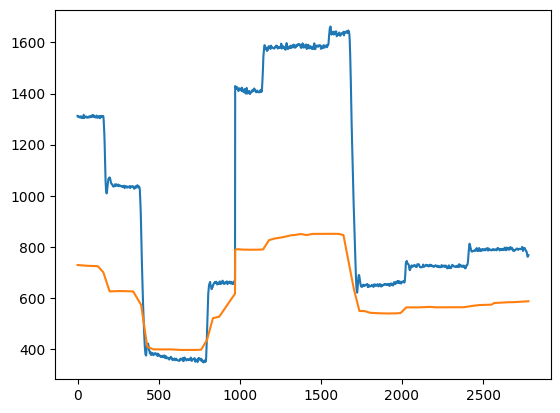

In [6]:
plt.plot(tot_data[0][1]['eye_X'])
plt.plot(tot_data[0][1]['tiny_X'])

In [7]:
import numpy as np
from scipy.optimize import dual_annealing, minimize

def find_optimal_transformation(X_tiny, X_eyelink, grid_size=100, scale_N=2, shift_N=3):
    """
    Find optimal scale and shift to transform X_tiny to match X_eyelink using dual annealing
    followed by gradient descent fine-tuning. Warns if optimal values are at boundaries.
    Handles positive and negative mean_diff for shift_range.
    
    Parameters:
    X_tiny: numpy array, input data to be transformed
    X_eyelink: numpy array, target data
    grid_size: int, number of points for range definition (used for bounds)
    scale_N: float, multiplier for scale range
    shift_N: float, multiplier for shift range
    
    Returns:
    best_scale, best_shift: optimal transformation parameters
    """
    
    # Define ranges for bounds
    scale_range = np.linspace(np.std(X_eyelink)/(scale_N*np.std(X_tiny)),
                             scale_N*np.std(X_eyelink)/np.std(X_tiny), grid_size)
    
    reverse_scaling = np.std(X_tiny)/np.std(X_eyelink)
    mean_diff = np.mean(X_eyelink) - np.mean(X_tiny)/reverse_scaling
    
    #print(f"Reverse scaling: {reverse_scaling:.4f}")
    #print(f"Mean difference: {mean_diff:.4f}")
    
    # Define shift_range, handling positive and negative mean_diff
    epsilon = 1e-6
    if mean_diff == 0:
        shift_range = np.linspace(-epsilon, epsilon, grid_size)
    else:
        center = reverse_scaling * mean_diff
        width = reverse_scaling * abs(mean_diff) * shift_N
        shift_range = np.linspace(center - width, center + width, grid_size)

    # Define bounds for dual annealing
    bounds = [(scale_range[0], scale_range[-1]), (shift_range[0], shift_range[-1])]
    
    # Objective function: MSE between transformed X_tiny and X_eyelink
    def objective(params):
        scale, shift = params
        transformed = scale * (X_tiny + shift)
        return np.mean((transformed - X_eyelink) ** 2)
    
    # Run dual annealing
    try:
        result = dual_annealing(objective, bounds, seed=42)
    except ValueError:
        return -1,-1
    best_scale, best_shift = result.x
    
    # Check if optimal values are at boundaries
    if np.isclose(best_scale, scale_range[0]) or np.isclose(best_scale, scale_range[-1]):
        print(f"Warning: Optimal scale ({best_scale:.4f}) is at the boundary of the grid "
              f"(range: [{scale_range[0]:.4f}, {scale_range[-1]:.4f}]). "
              "Consider increasing the scale_N or grid_size.")
    if np.isclose(best_shift, shift_range[0]) or np.isclose(best_shift, shift_range[-1]):
        print(f"Warning: Optimal shift ({best_shift:.4f}) is at the boundary of the grid "
              f"(range: [{shift_range[0]:.4f}, {shift_range[-1]:.4f}]). "
              "Consider increasing the shift_N or grid_size.")
    
    # Gradient descent fine-tuning using BFGS
    result = minimize(objective, x0=[best_scale, best_shift], method='BFGS')
    best_scale, best_shift = result.x
    
    return best_scale, best_shift

#

In [8]:
eye_link_color = '#1F4E79'
tiny_color = '#F28C38'

In [18]:
for i in range(0,len(tot_data)):
    print(i)
    for j in range(len(tot_data[i])):
        scale, shift = find_optimal_transformation(tot_data[i][j]['tiny_X'], tot_data[i][j]['eye_X'], grid_size=10, scale_N=5, shift_N=5)
        if scale == -1:
            1
        else:
            tot_data[i][j]['new_tiny_X'] = (tot_data[i][j]['tiny_X']+shift)*scale

        
        

0
1
2
3
4
5


0


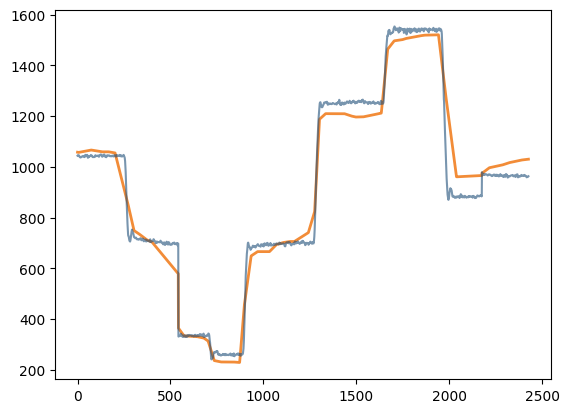

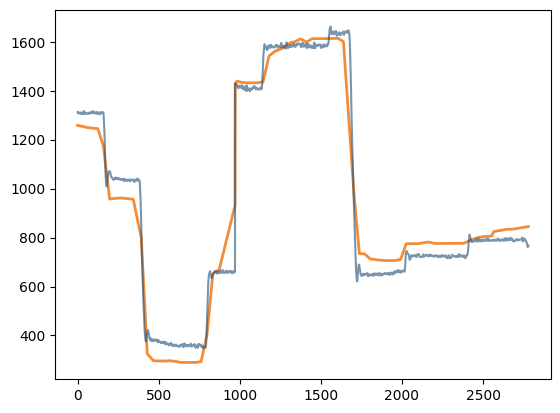

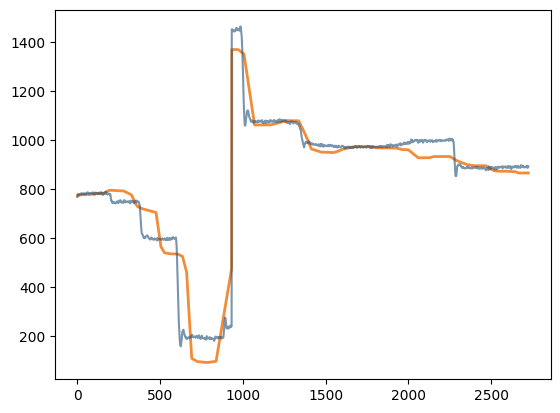

1


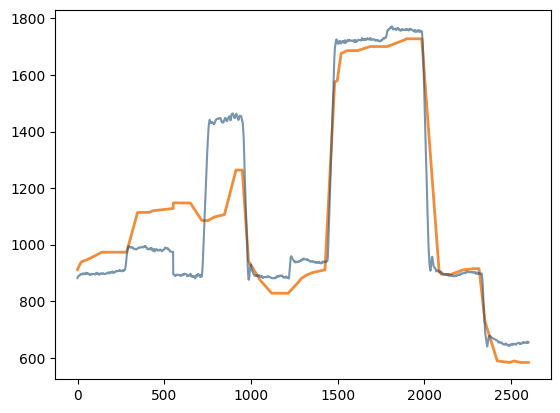

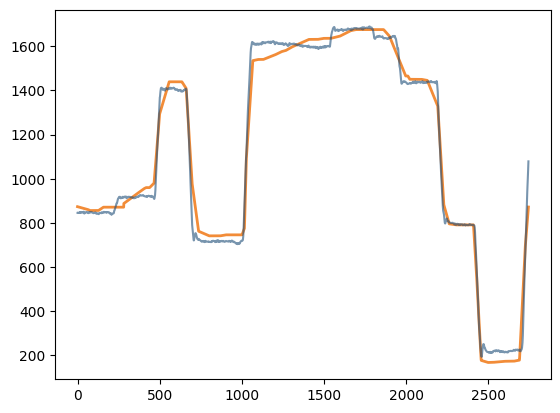

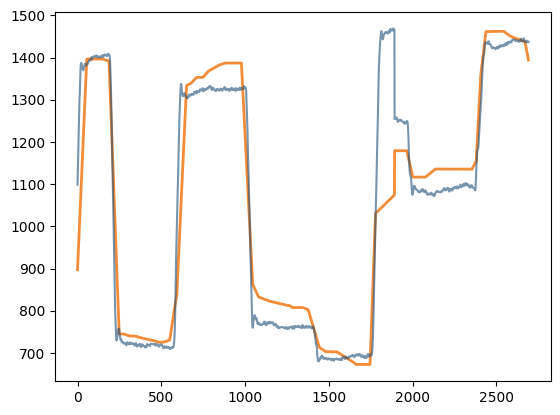

2


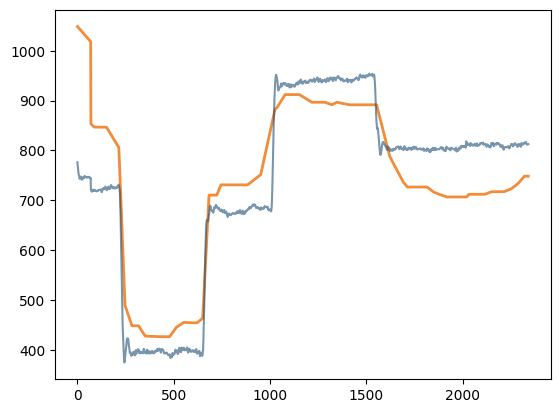

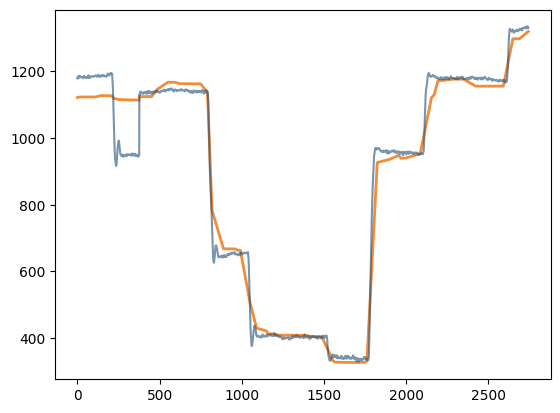

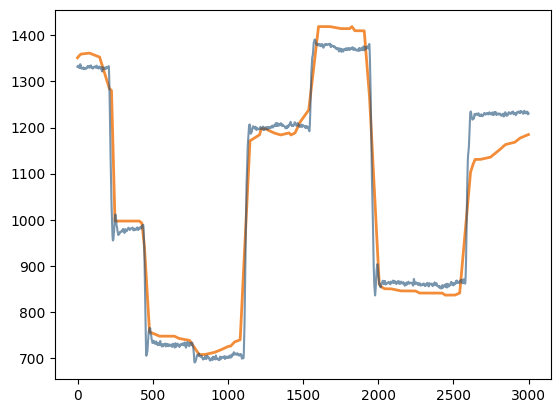

3


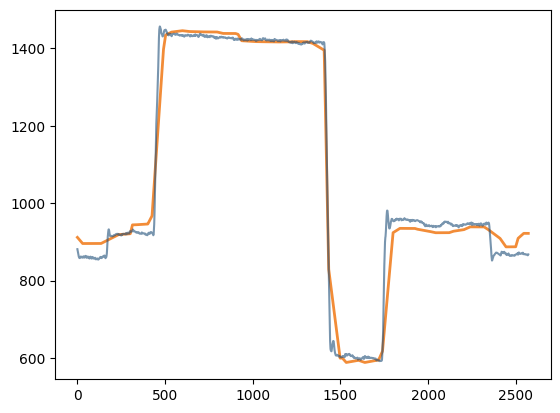

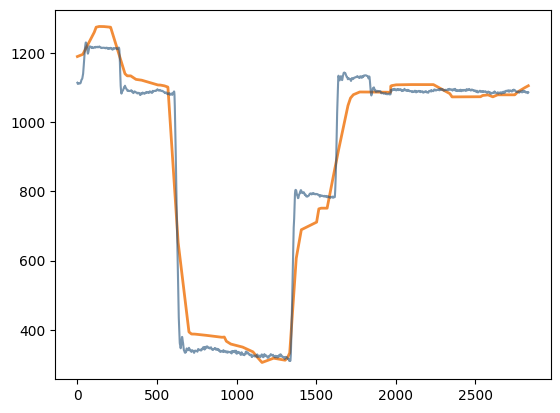

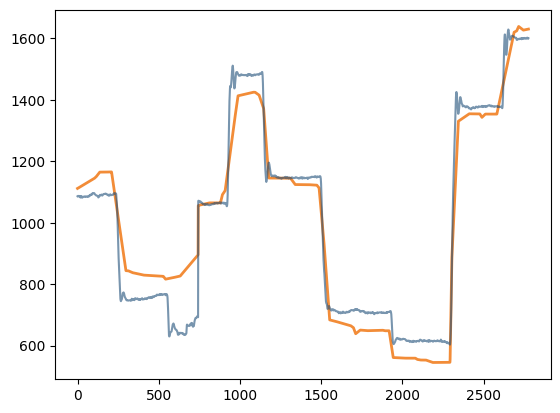

4


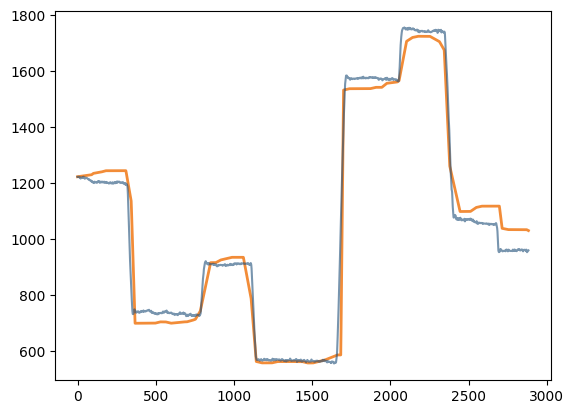

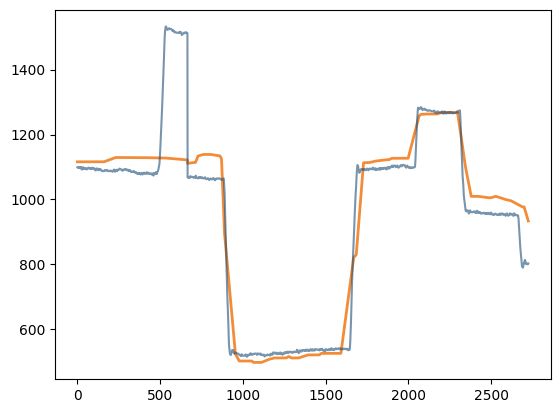

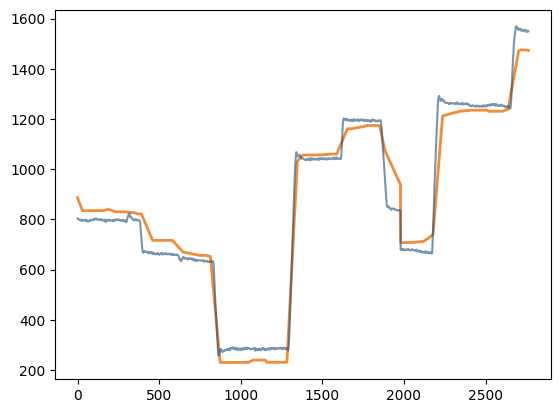

5


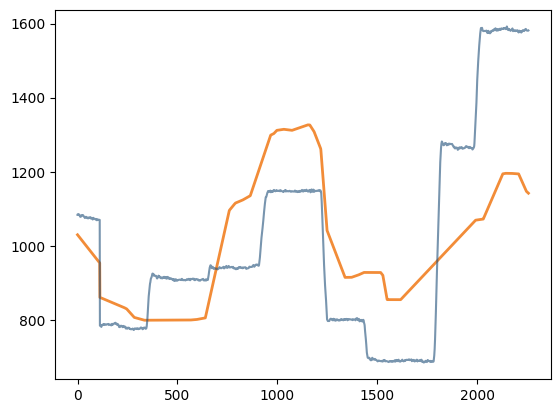

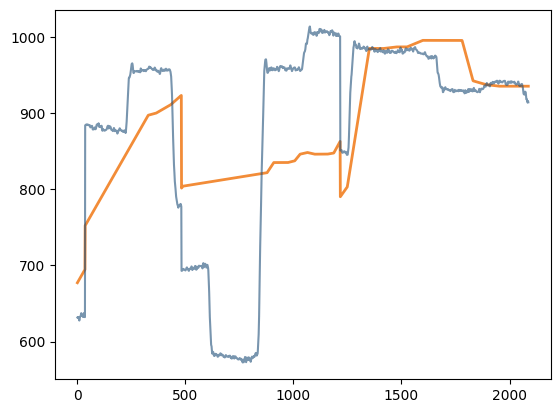

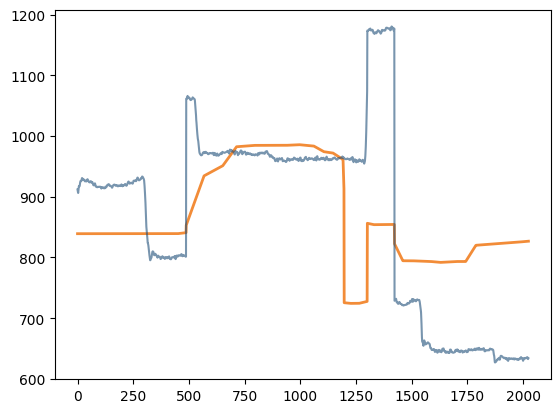

6


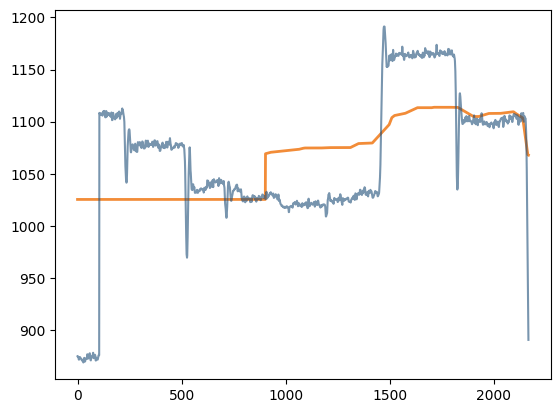

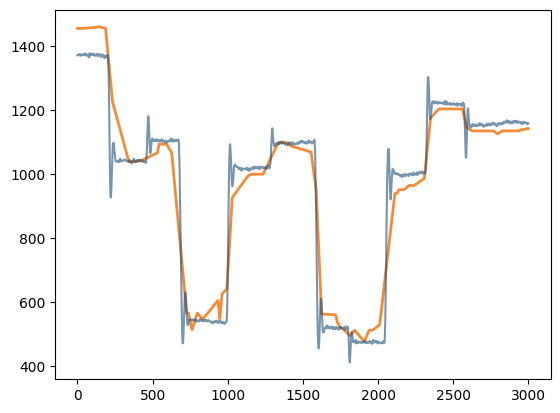

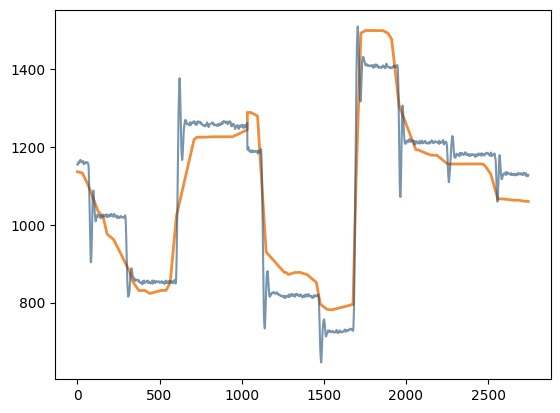

7


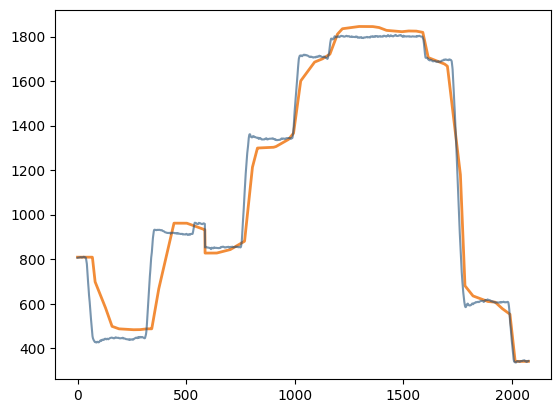

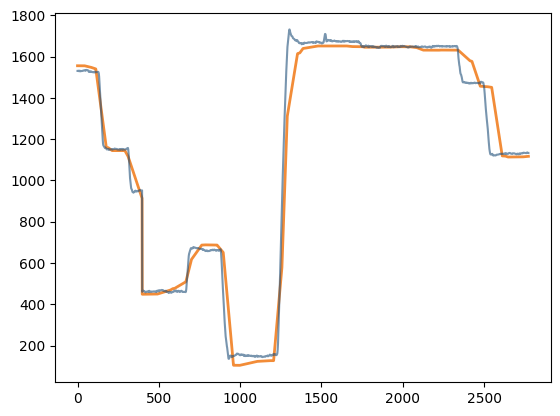

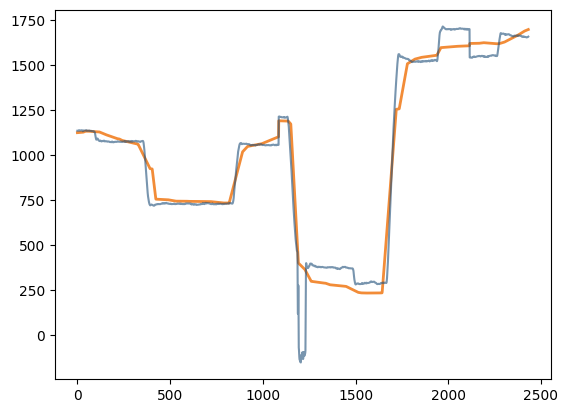

8


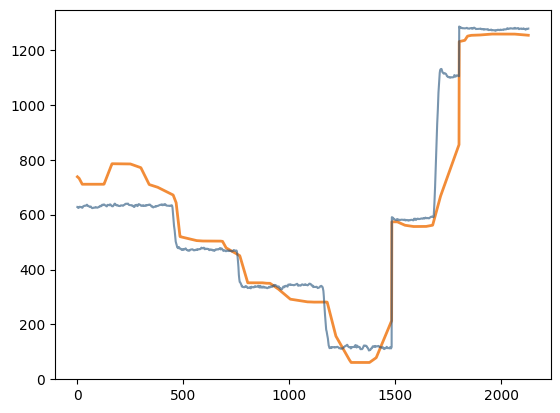

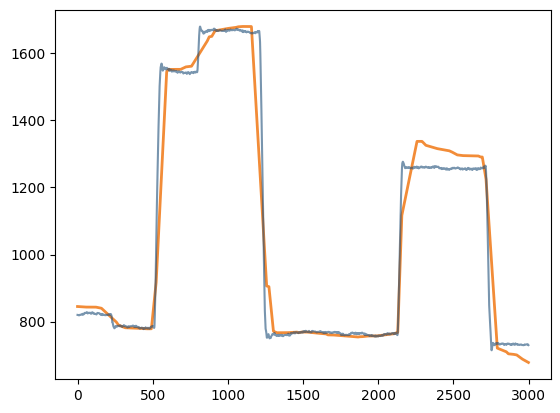

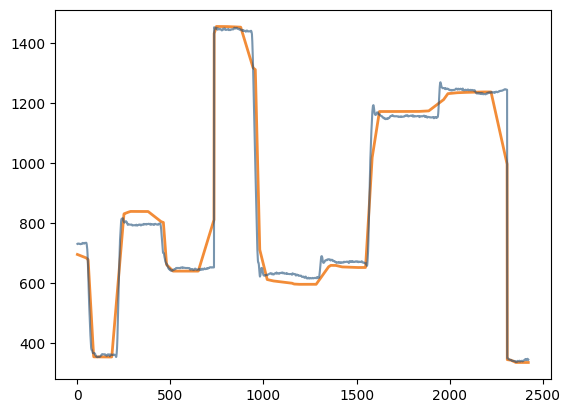

9


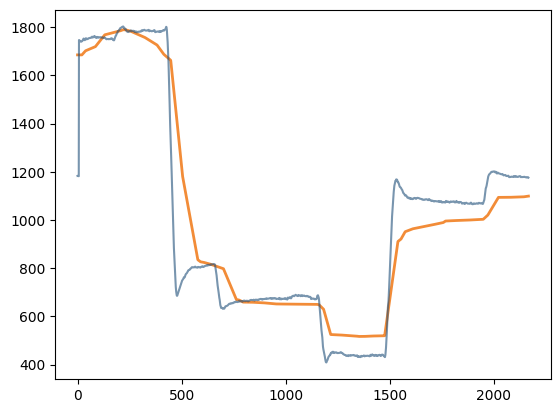

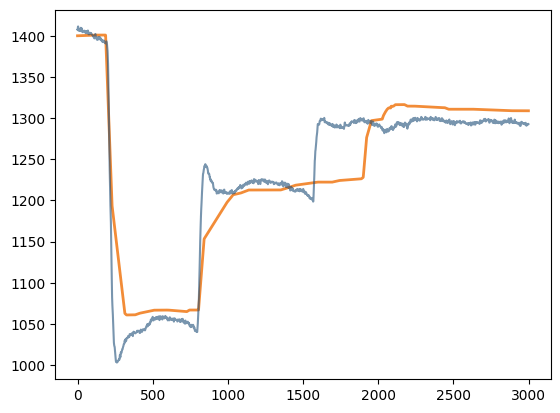

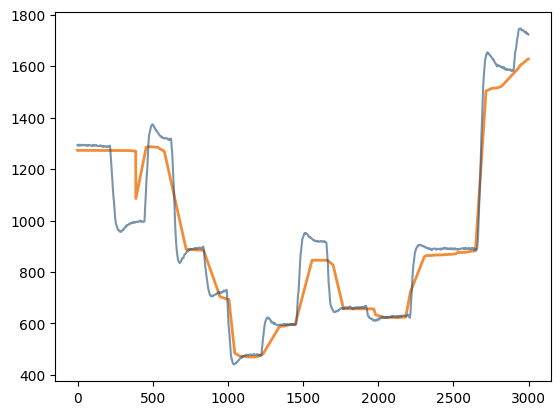

10


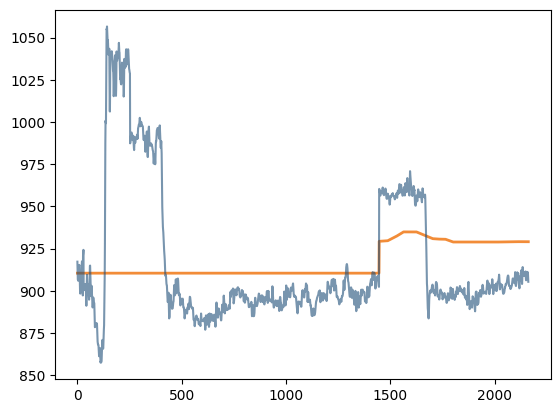

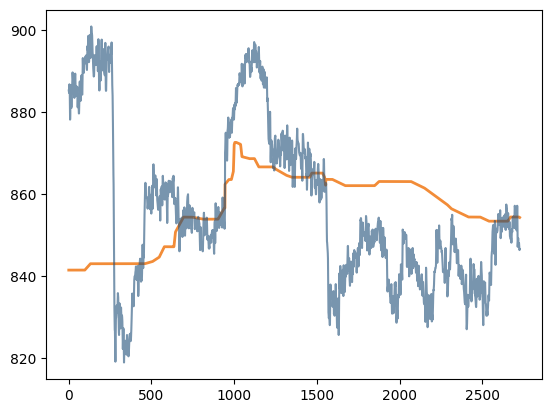

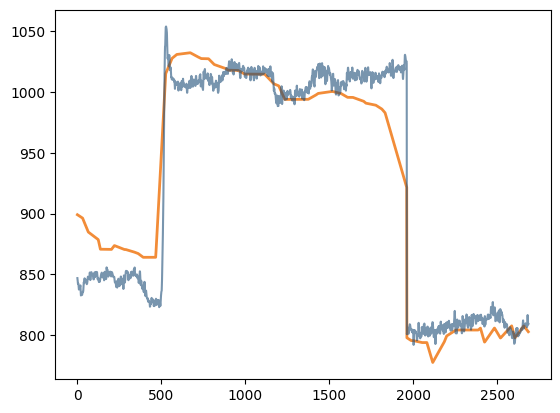

11


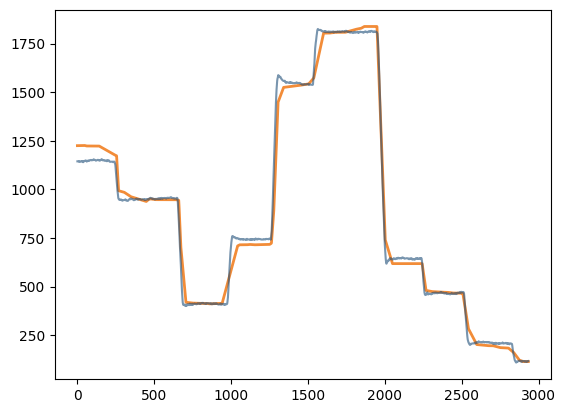

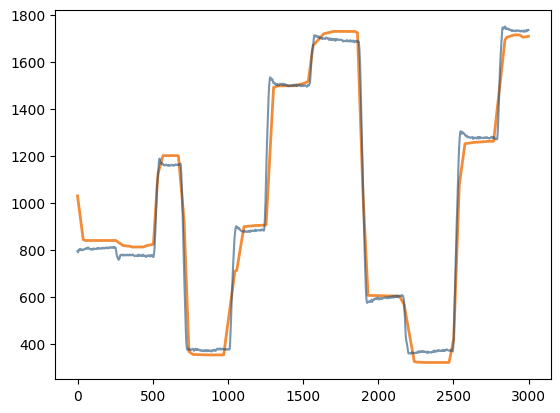

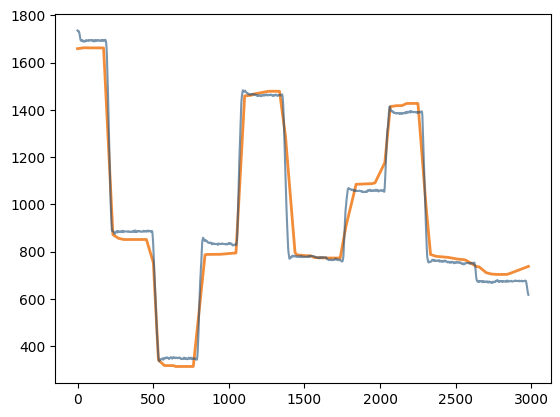

12


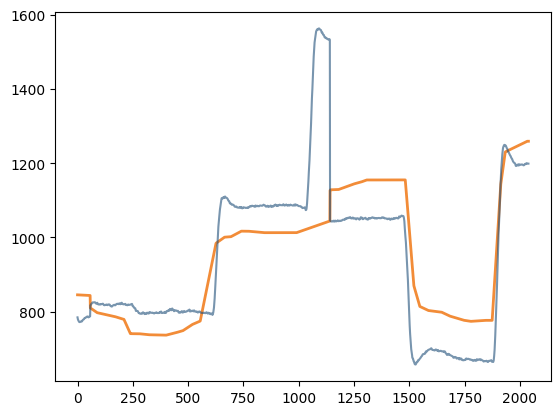

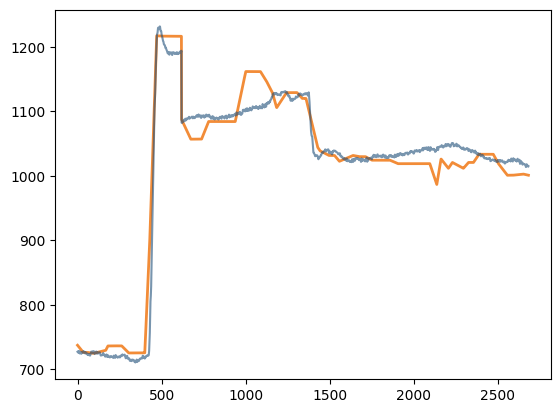

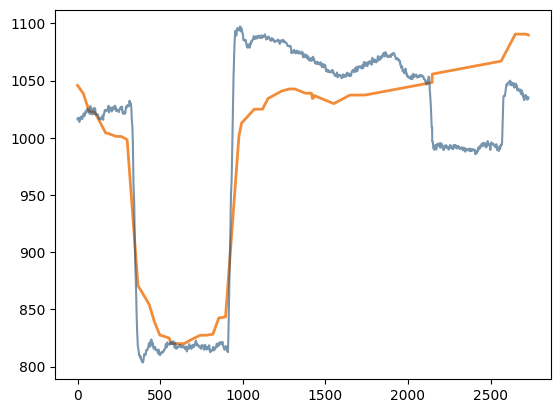

13


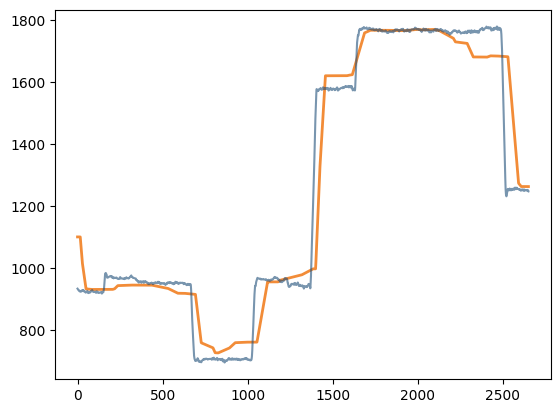

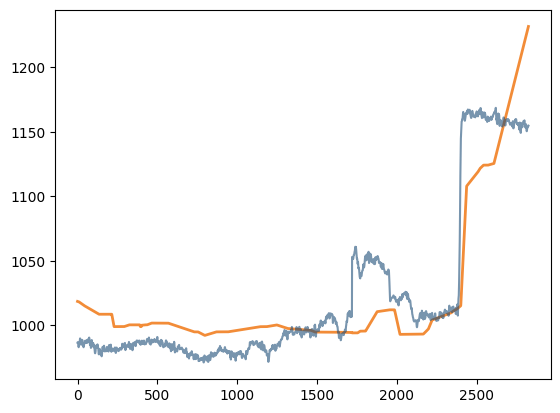

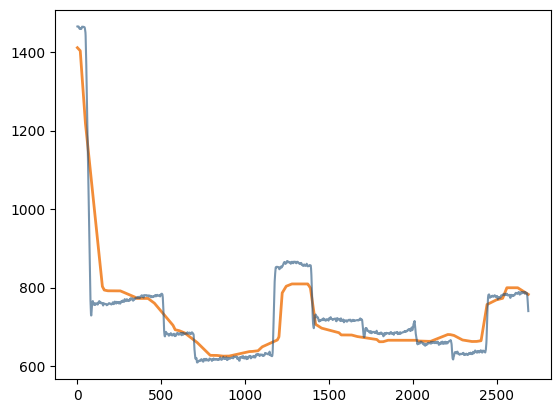

14


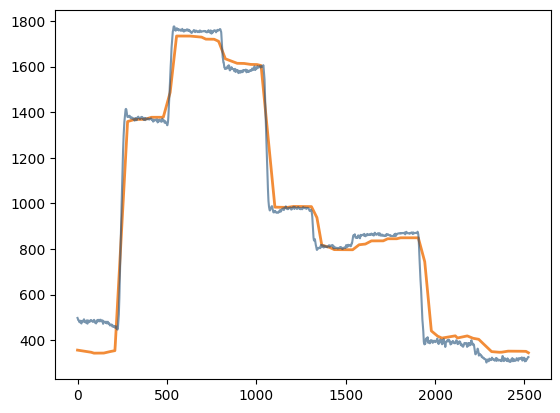

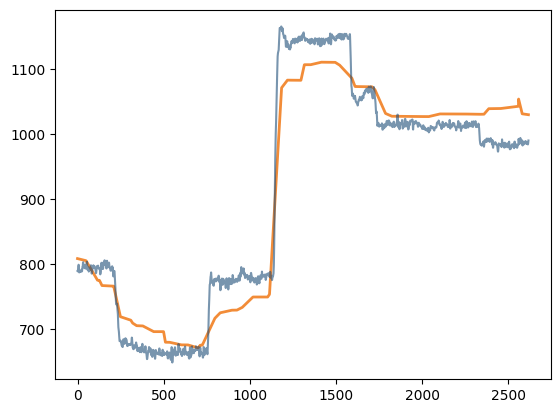

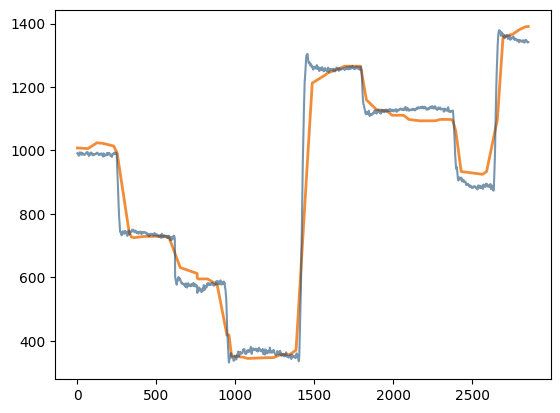

15


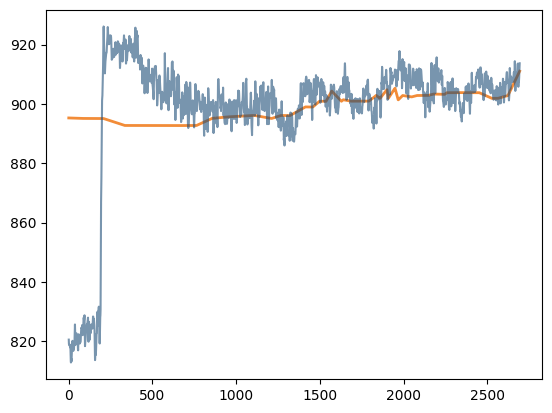

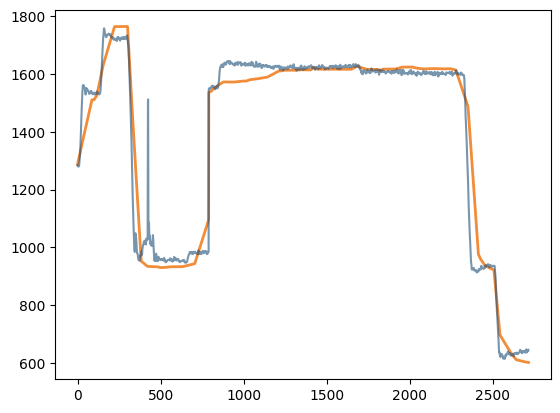

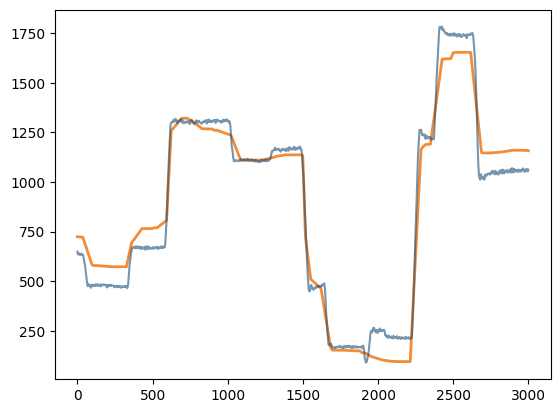

16


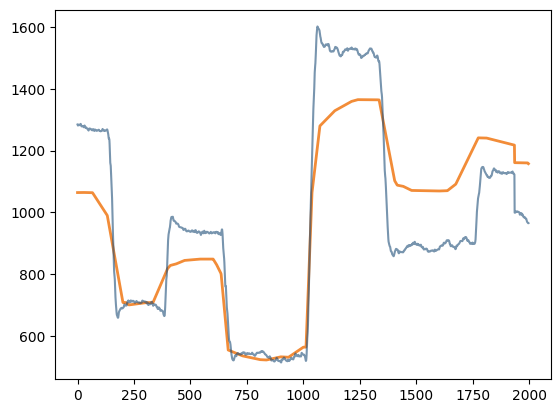

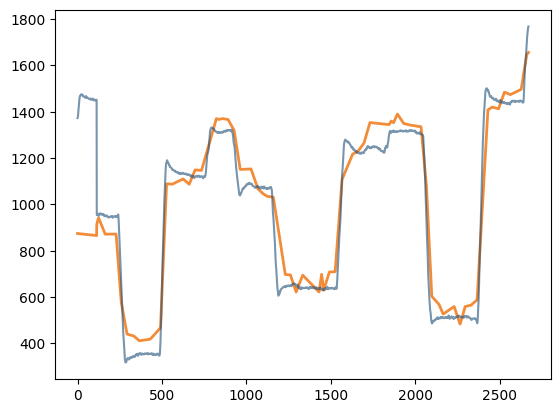

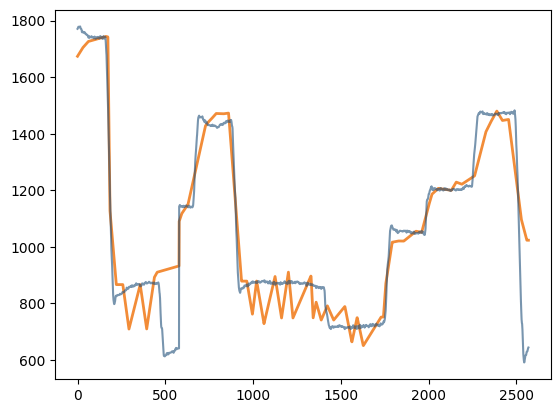

17


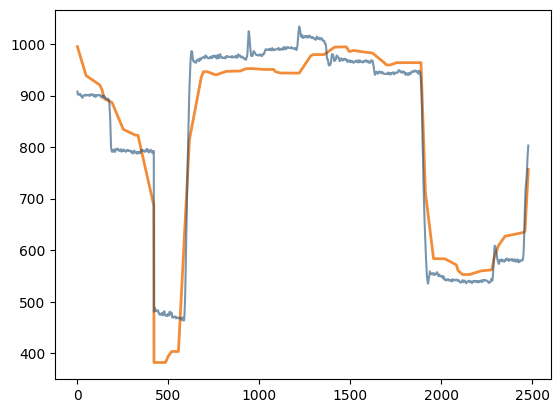

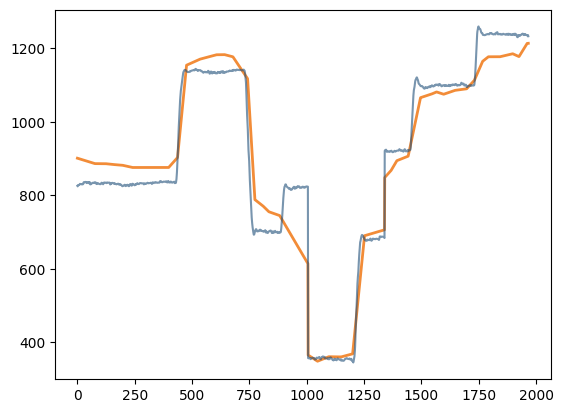

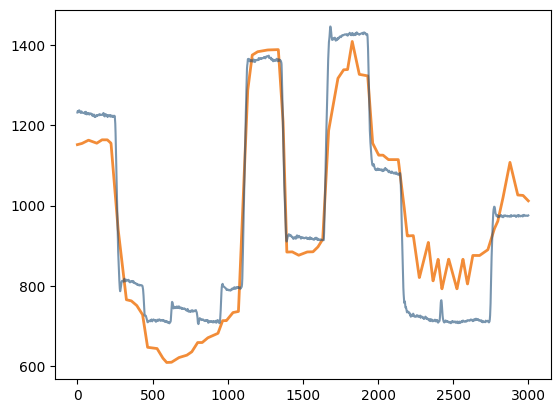

18


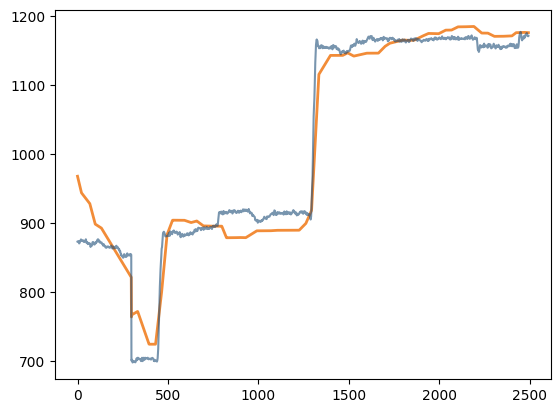

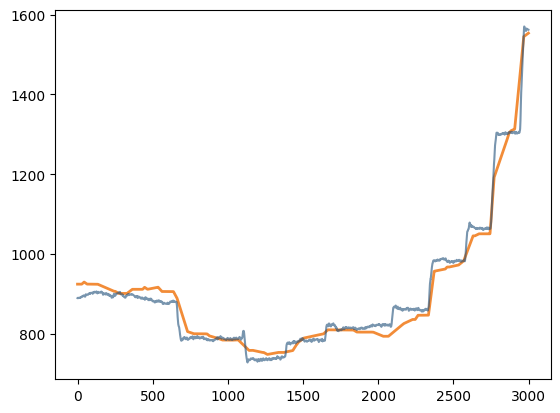

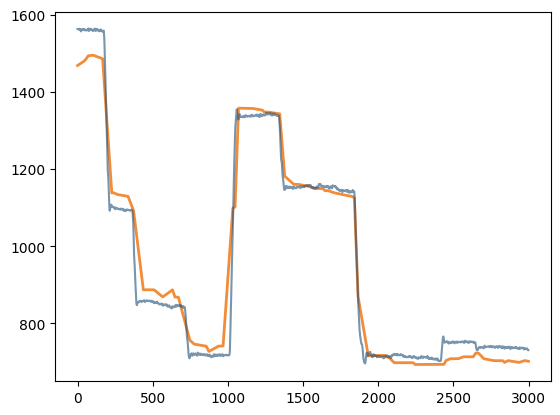

19


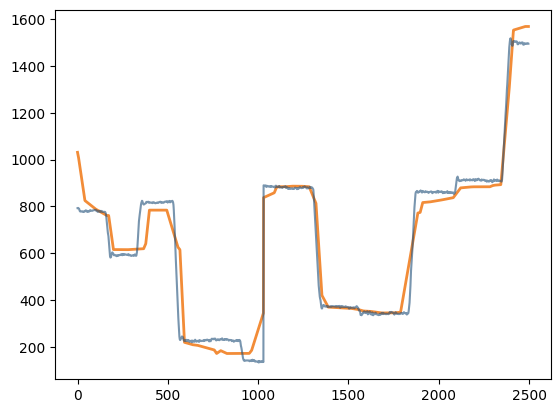

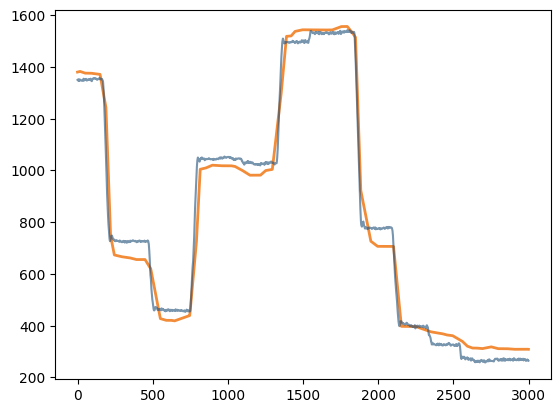

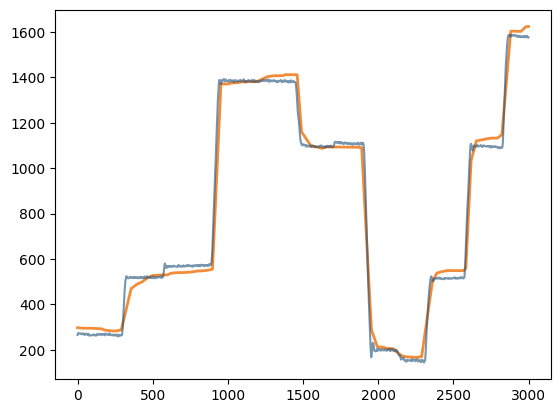

20


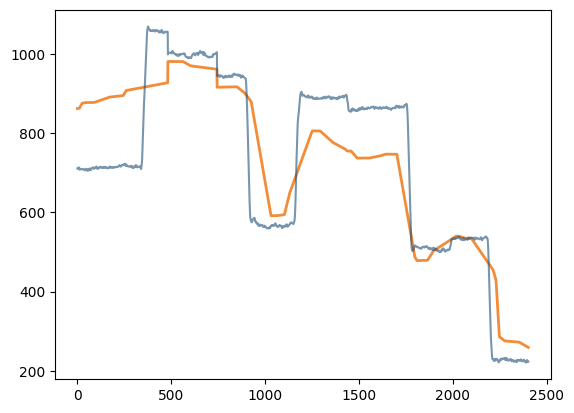

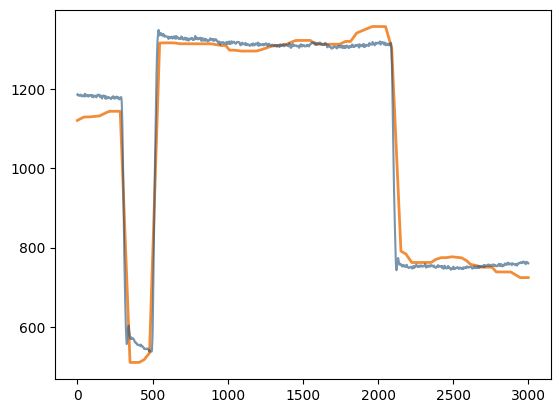

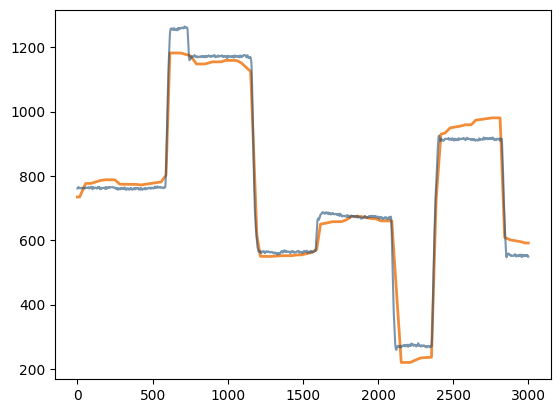

21


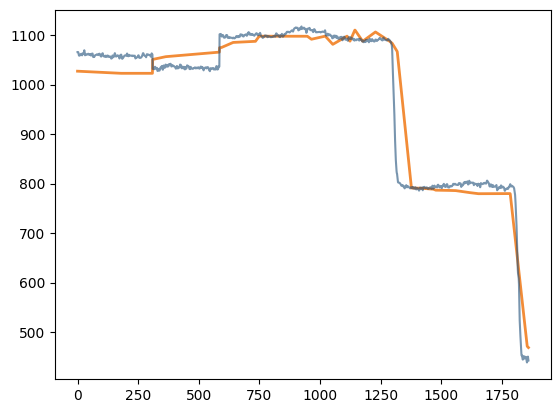

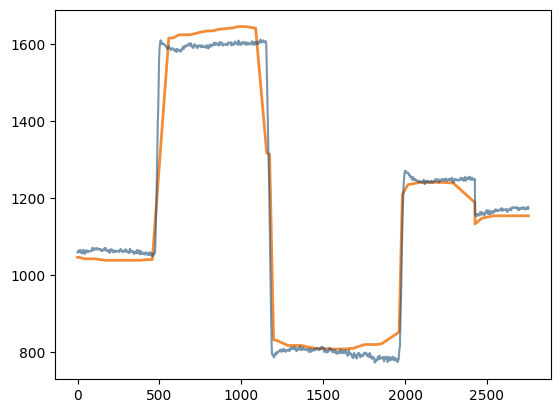

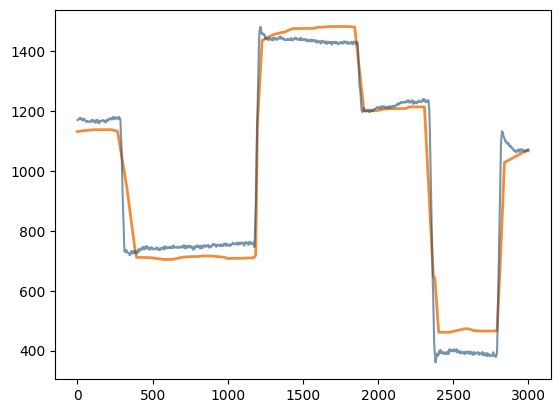

22


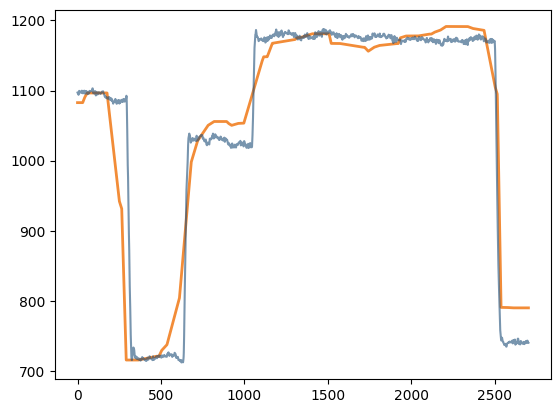

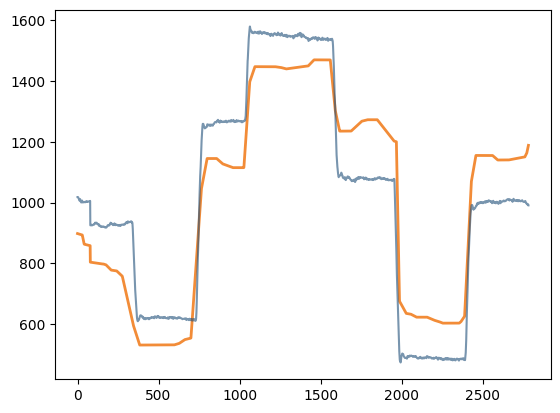

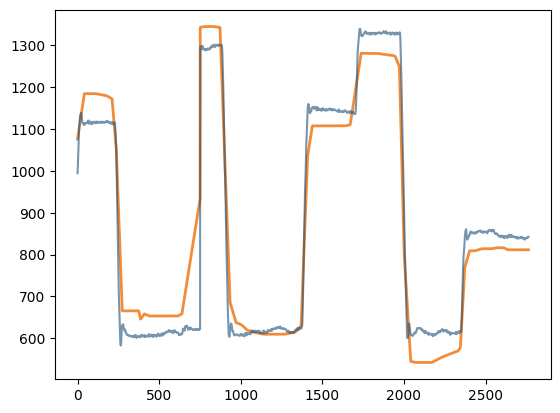

23


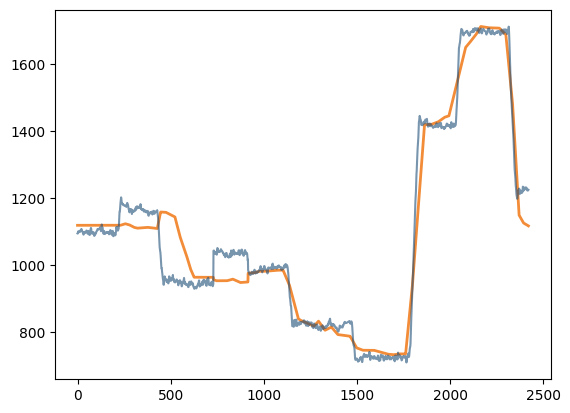

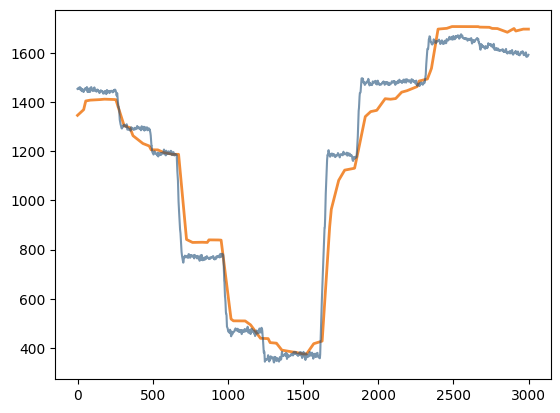

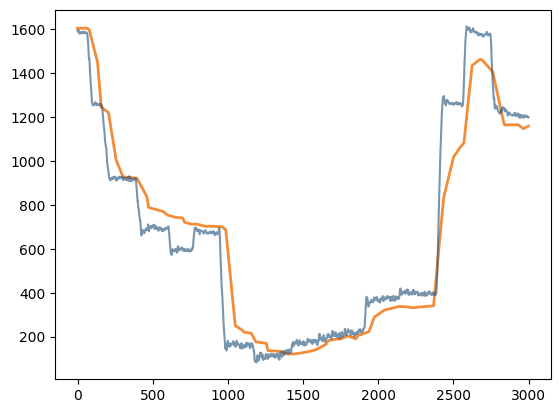

24


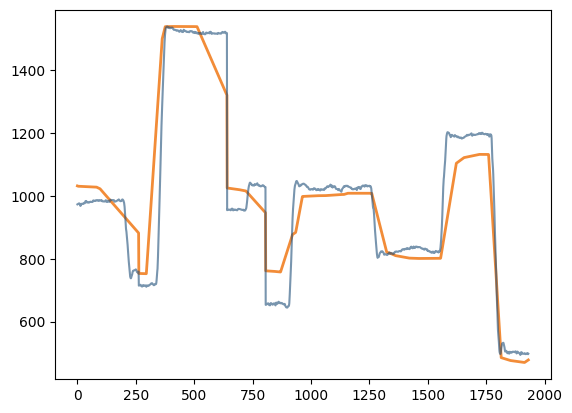

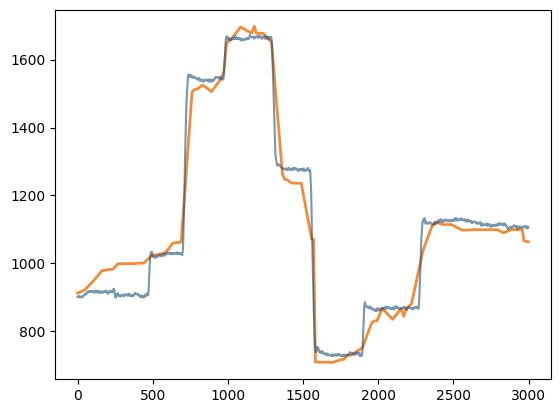

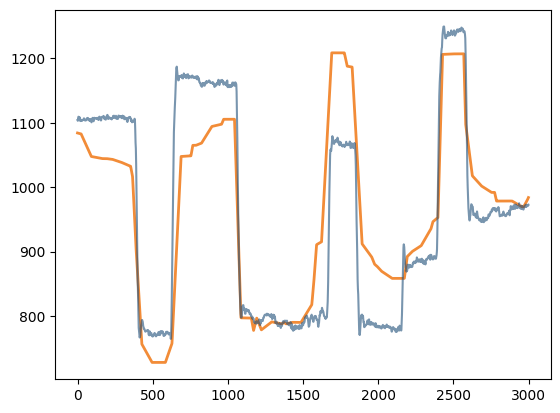

25


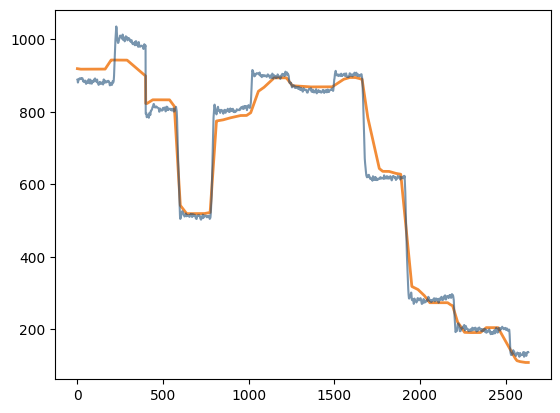

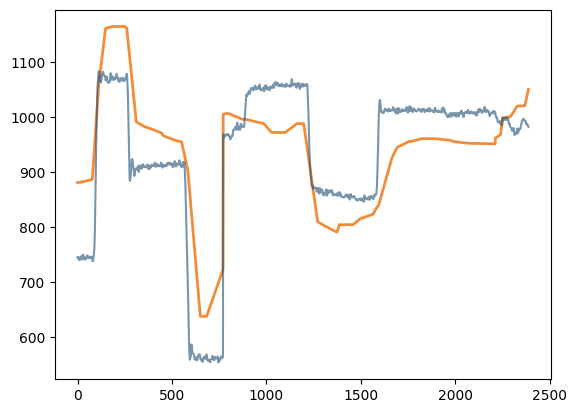

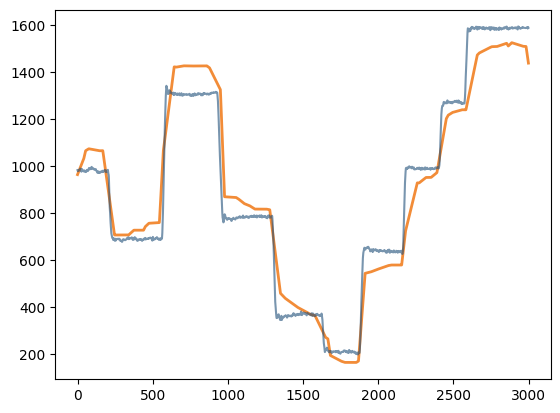

26


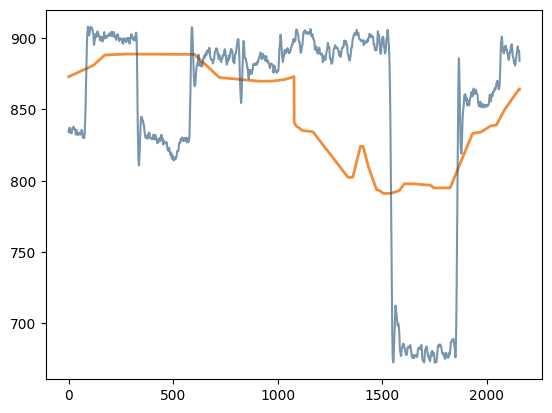

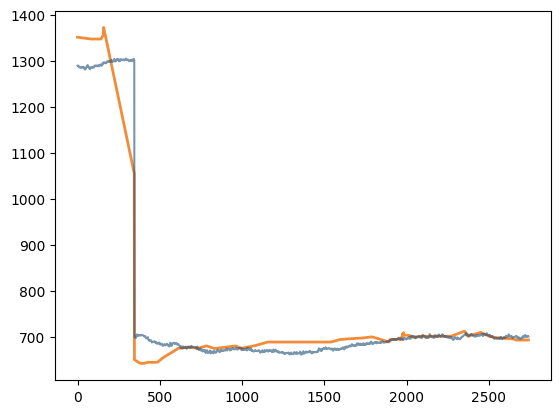

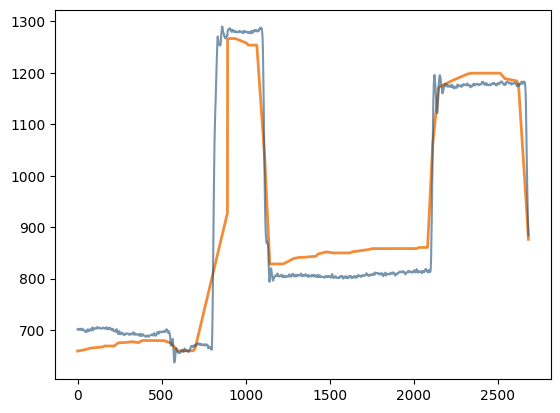

27


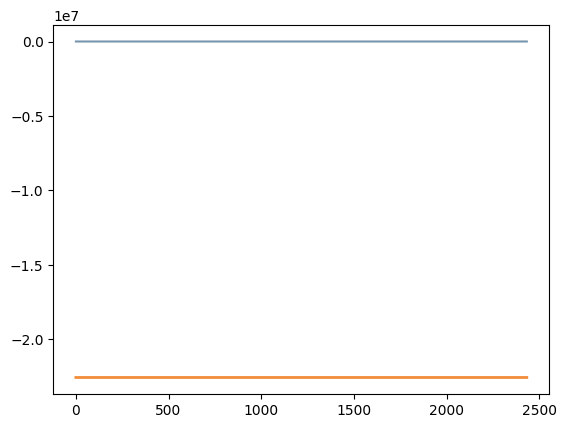

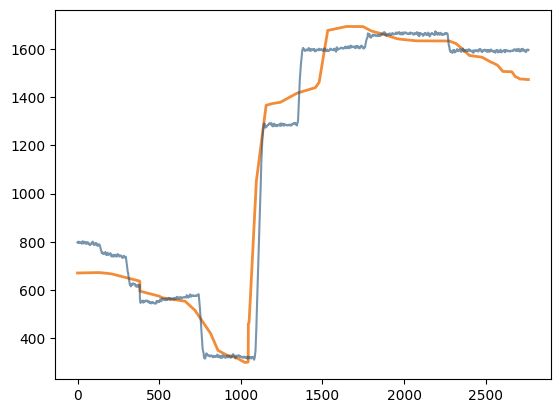

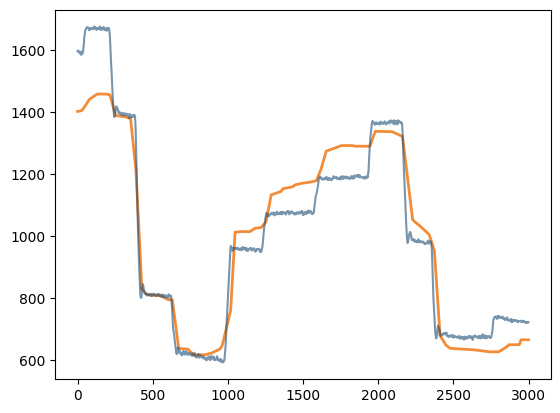

28


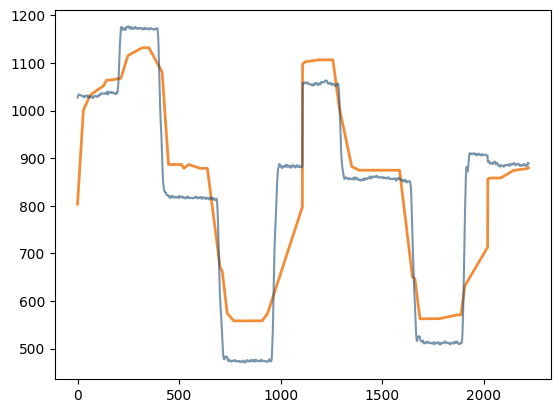

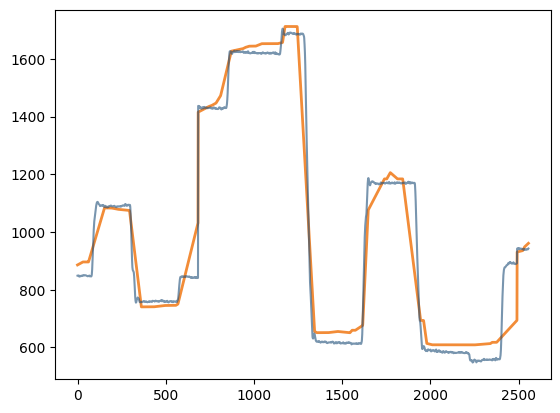

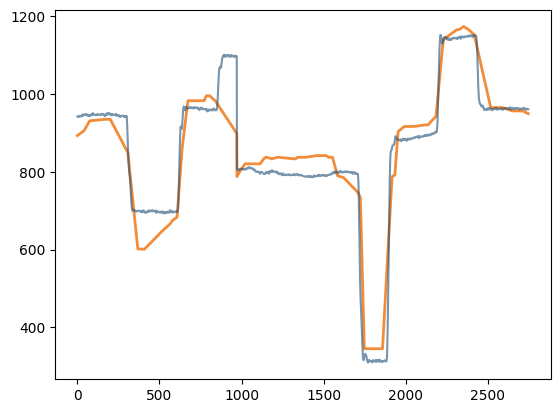

29


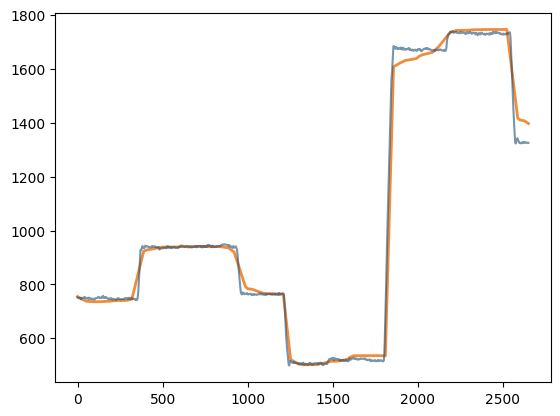

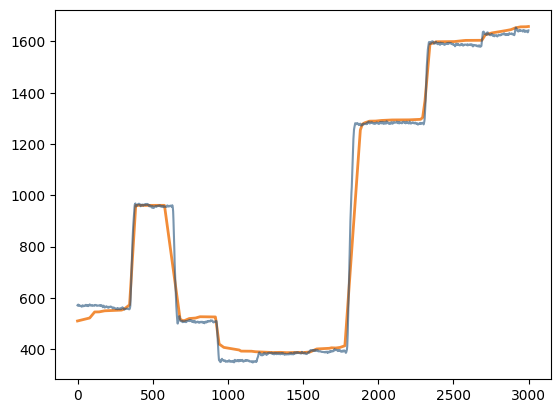

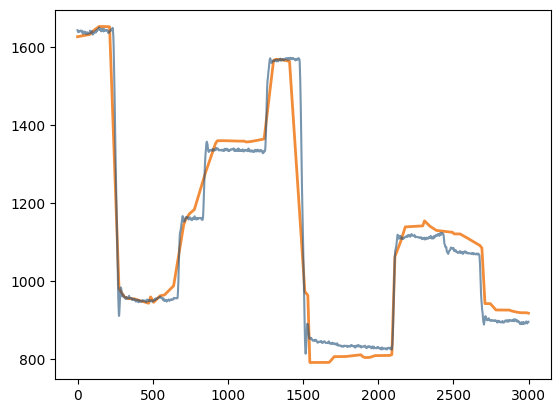

30


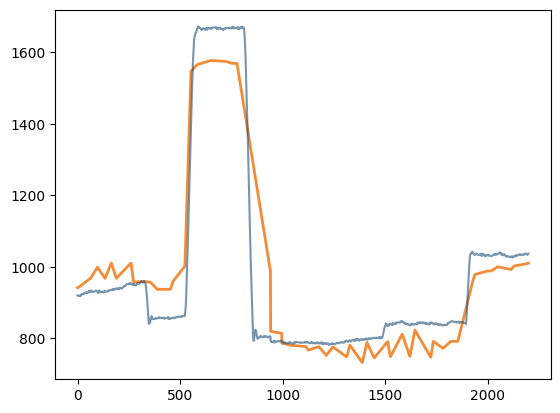

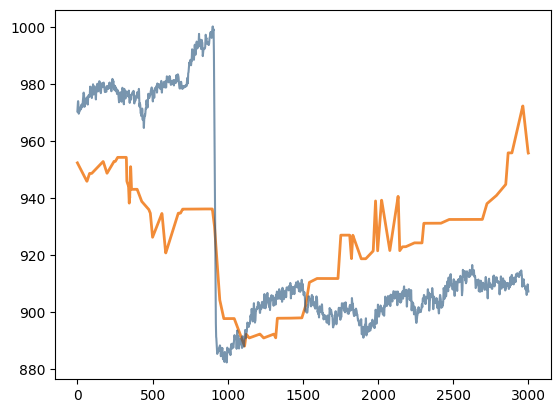

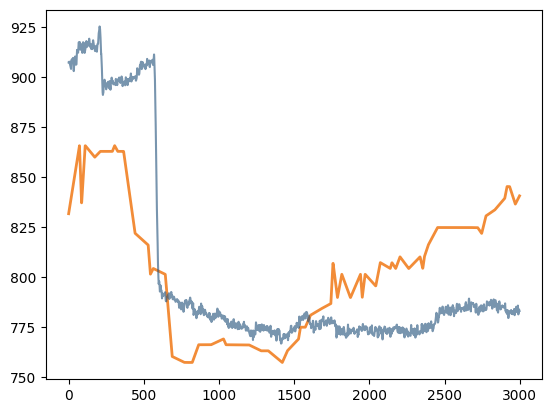

31


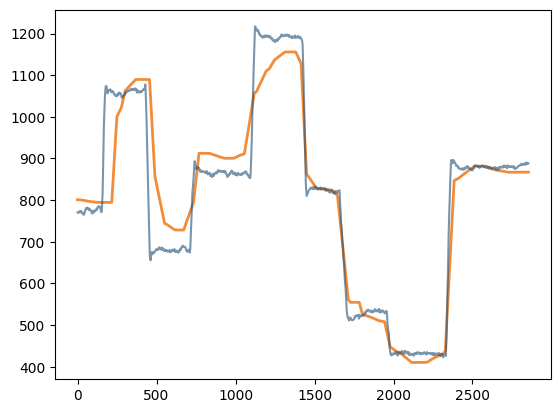

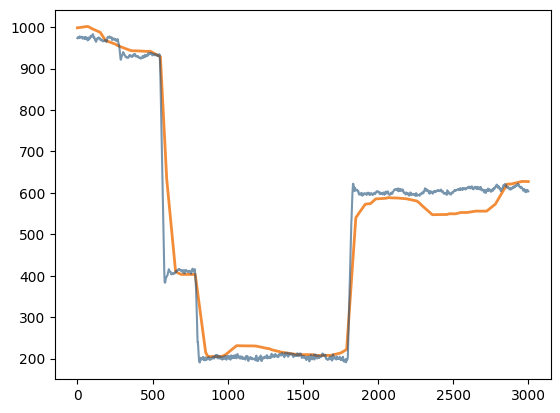

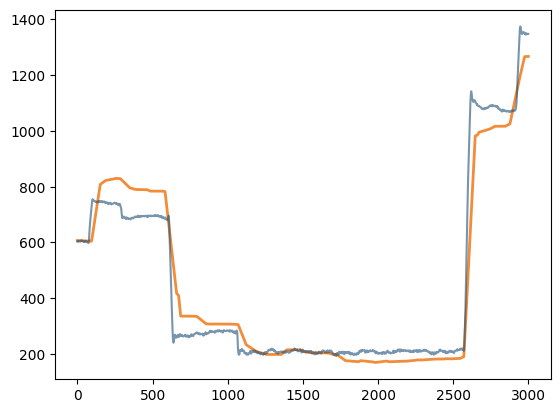

32


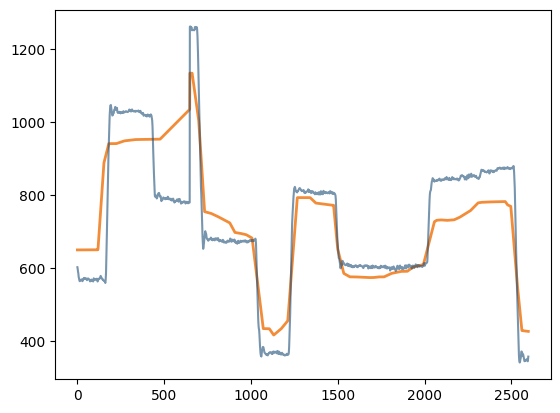

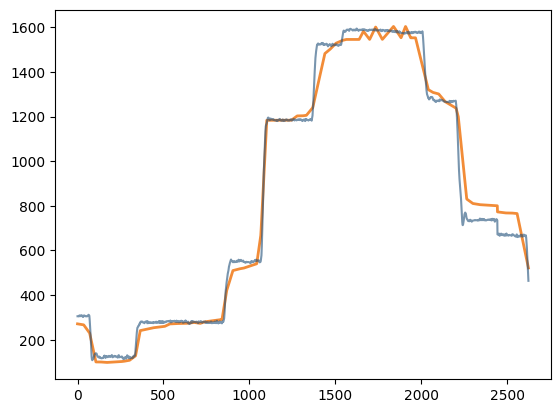

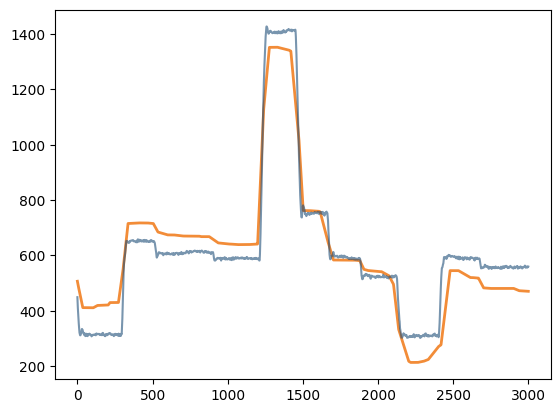

33


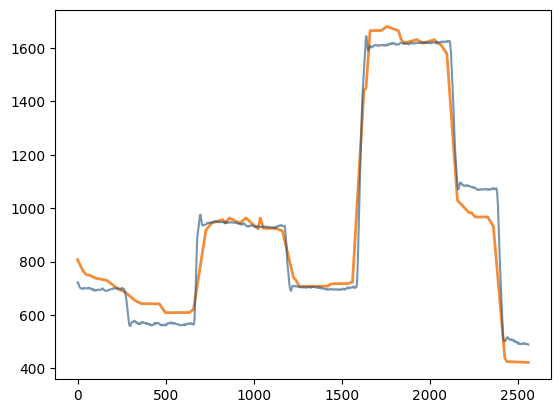

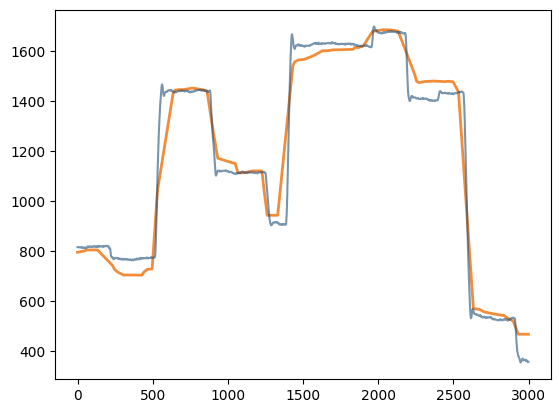

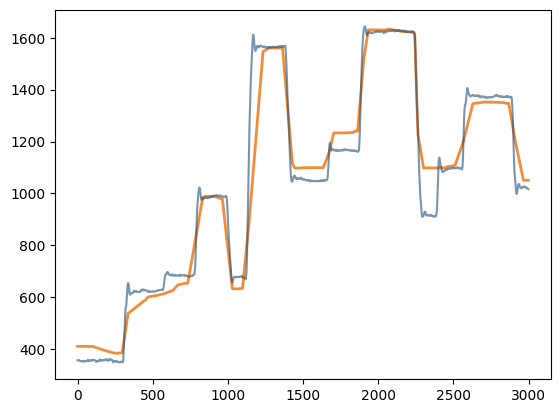

34


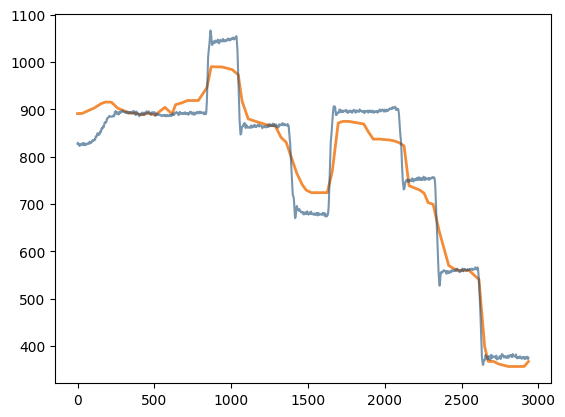

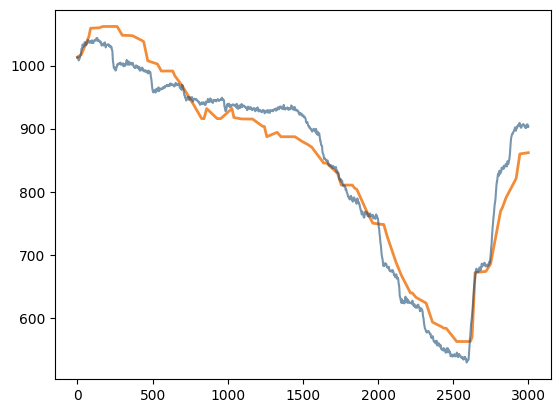

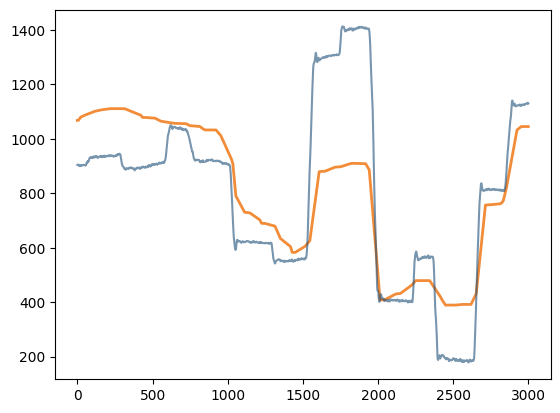

35


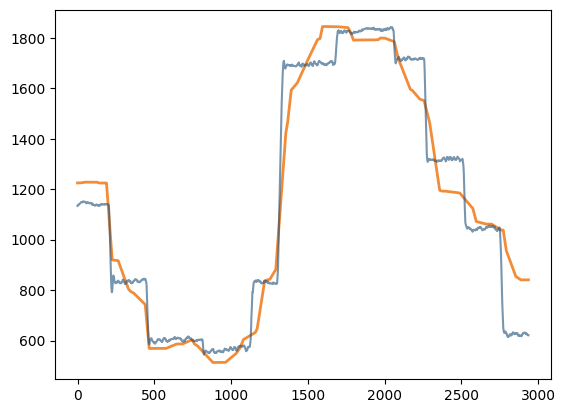

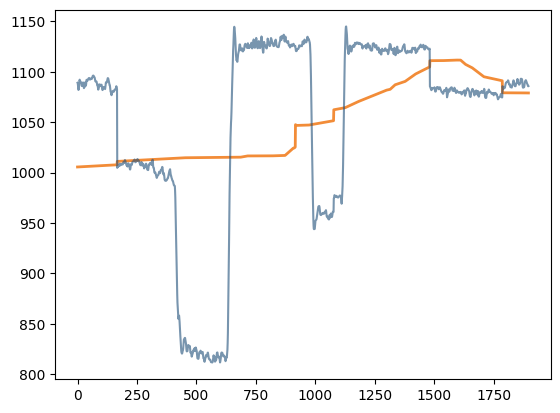

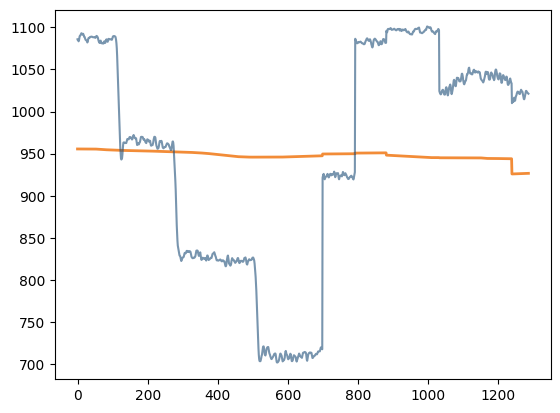

36


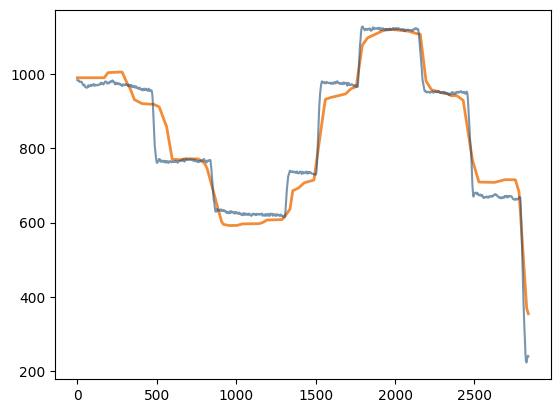

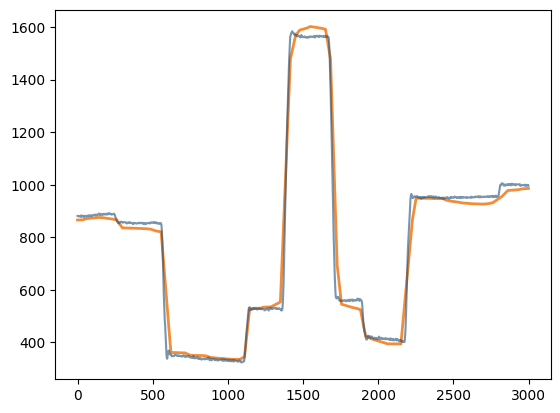

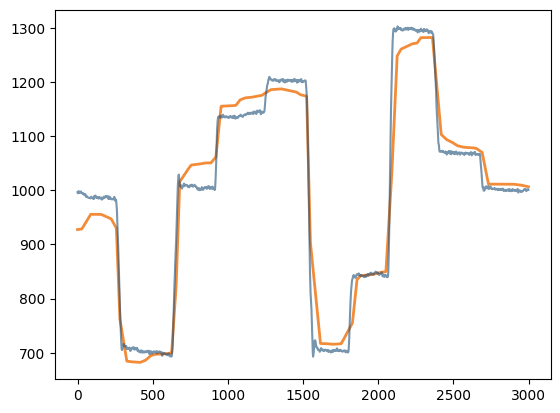

37


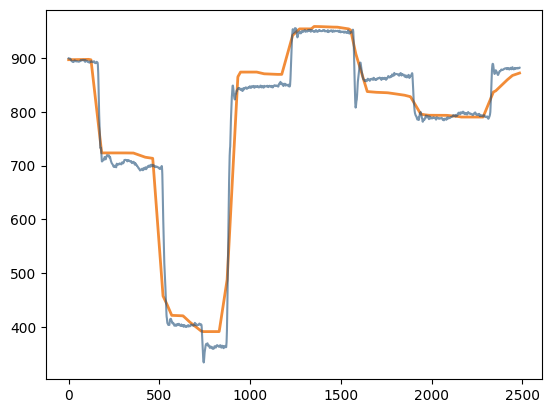

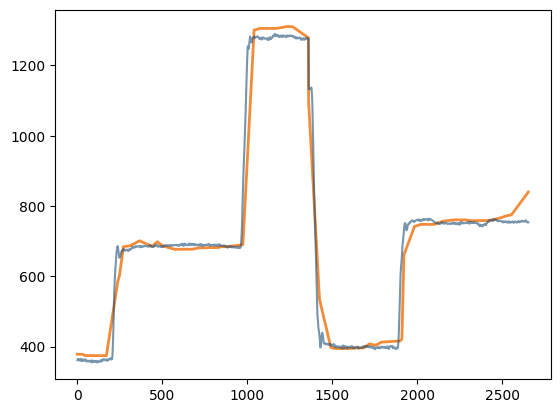

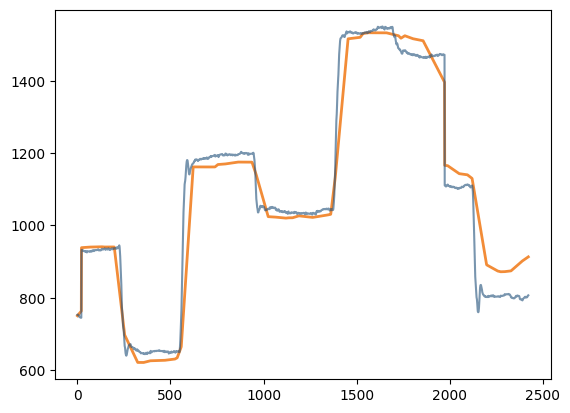

38


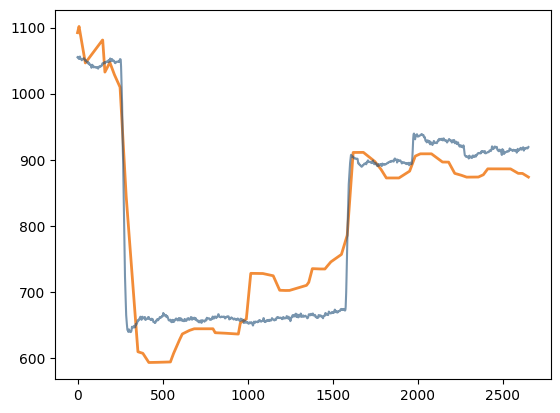

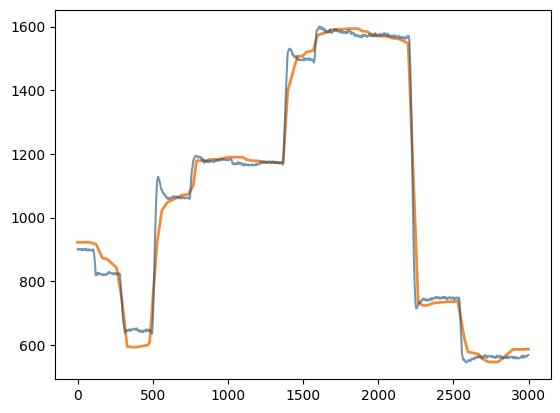

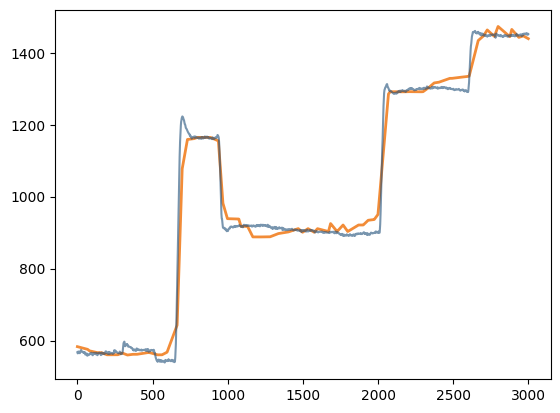

In [19]:
for i in range(len(tot_data)):
    print(i)
    for j in range(3):
        plt.plot(tot_data[i][j]['new_tiny_X'],c=tiny_color,linewidth=2)
        plt.plot(tot_data[i][j]['eye_X'],c=eye_link_color,linewidth=1.5,alpha=0.6)
        plt.show()

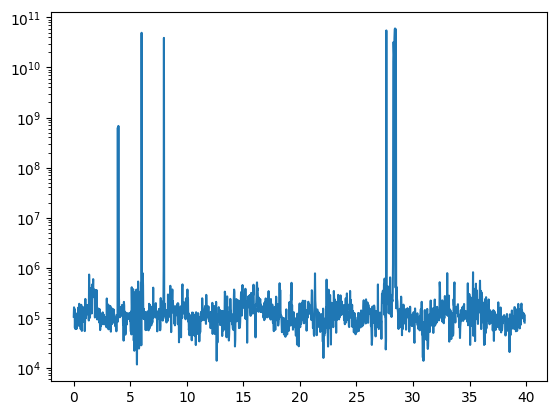

In [20]:
d_sq = []
for i in range(len(tot_data)):
    #print(i)
    for j in range(len(tot_data[i])):
        try:
            d_sq.append(np.sum(np.abs(tot_data[i][j]['new_tiny_X']-tot_data[i][j]['eye_X'])))
        except KeyError:
            1

plt.plot(np.arange(len(d_sq))/len(tot_data[i]),d_sq)
plt.yscale('log')
        

In [22]:
part_exclude = [5]
temp_explore_part_tiny = []
mean_explore_part_eye = []
mean_explore_part_tiny = []

time_interval = 40
overlap = 25
X_min = - 100
X_max = 3000
X_inc = 100
Xbins = np.arange(X_min,X_max,X_inc)


for i in range(len(tot_data)):
    if i not in part_exclude:
        for j in range(len(tot_data[i])):

            try:

    
                X_tiny= tot_data[i][j]['new_tiny_X']
                occu_matrix=np.histogram( X_tiny[::time_interval] , bins=Xbins,density= False)[0]
                explore_matrix=np.where(occu_matrix != 0, 1, 0)
                temp_explore_part_tiny.append(np.sum(explore_matrix))
                mean_explore_part_tiny.append(temp_explore_part_tiny)
                
                X_eye = tot_data[i][j]['eye_X']
                temp_explore_part_eye = []
    
                occu_matrix=np.histogram( X_eye[::time_interval] , bins=Xbins,density= False)[0]
                explore_matrix=np.where(occu_matrix != 0, 1, 0)
                temp_explore_part_eye.append(np.sum(explore_matrix))
                mean_explore_part_eye.append(temp_explore_part_eye)
    
                temp_explore_part_tiny = []
            except KeyError:
                1



mean_explore_part_eye  = np.array(np.hstack(mean_explore_part_eye))
mean_explore_part_tiny  = np.array(np.hstack(mean_explore_part_tiny))

In [23]:
np.hstack(mean_explore_part_eye)

array([ 9,  9, 10, ...,  5,  6,  8])

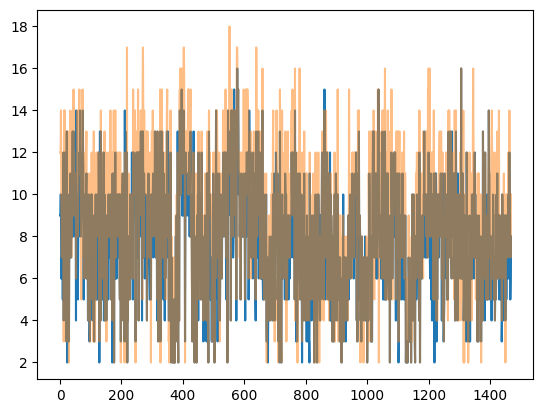

In [24]:
mask1 = mean_explore_part_tiny>1
mask2 = mean_explore_part_eye>1
mask = mask1*mask2

plt.plot(mean_explore_part_eye[mask])
plt.plot(mean_explore_part_tiny[mask],alpha=0.5)

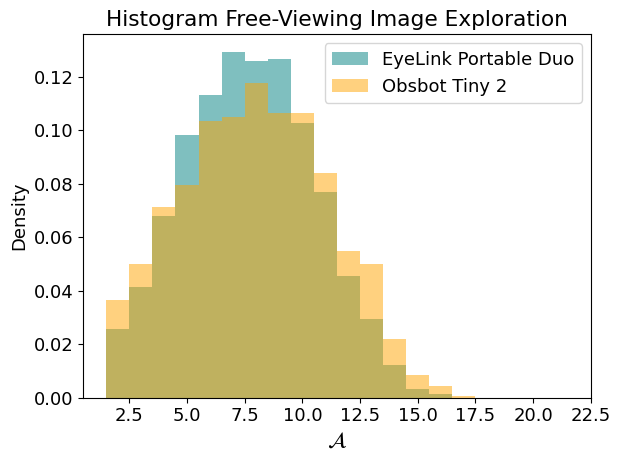

In [25]:
matplotlib.rcParams.update({'font.size': 13})

plt.hist(mean_explore_part_eye[mask],np.arange(1.5,22.5),density=True,alpha=0.5,color='teal',label='EyeLink Portable Duo');
plt.hist(mean_explore_part_tiny[mask]-1,np.arange(1.5,22.5),density=True,alpha=0.5,color='orange',label='Obsbot Tiny 2');
plt.xlabel(r'$\mathcal{A}$',fontsize=16)
plt.ylabel(r'Density')
plt.title('Histogram Free-Viewing Image Exploration')
plt.legend()
plt.tight_layout()
plt.savefig('free_viewing.png',dpi=300)



In [30]:
np.savetxt("free_viewing_eye_link.txt",mean_explore_part_eye[mask])

In [31]:
np.savetxt("free_viewing_tiny.txt",mean_explore_part_tiny[mask])

In [26]:
def to_quantiles(arr):
    """
    Transform an array so each value is replaced by its quantile in the distribution.
    
    Parameters:
    arr: numpy array, input data to be transformed
    
    Returns:
    quantiles: numpy array, quantile values (between 0 and 1) corresponding to each input value
    """
    # Convert input to numpy array
    arr = np.asarray(arr)
    
    # Get ranks (using 'average' method for ties)
    ranks = np.argsort(np.argsort(arr, kind='mergesort'))  # Stable sort for consistency
    n = len(arr)
    #print(ranks)
    # Convert ranks to quantiles: (rank + 0.5) / n for centered quantiles
    quantiles = (ranks + 0.5) / n
    
    return quantiles

In [27]:
qt_eye = to_quantiles(np.hstack(mean_explore_part_eye))
qt_tiny = to_quantiles(np.hstack(mean_explore_part_tiny))

In [28]:
np.corrcoef(qt_eye, qt_tiny)[0, 1]

0.8590041995209066

In [29]:
qt_tiny

array([0.79056728, 0.79122691, 0.79188654, ..., 0.38159631, 0.38225594,
       0.69030343])